# **Метод потенциальных барьеров на примере системы обыкновенных дифференциальных уравнений(ОДУ) второго порядка**

### Алексей Филаткин
по статье 
<a href="https://doi.org/10.1016/j.automatica.2008.11.017">Barrier Lyapunov Functions for the control of output-constrained nonlinear systems</a>

Задана система ОДУ специального вида:
 \begin{cases}
   \dot x_{1}(t) = f_{1}(x_{1}) + g_{1}(x_{1})x_{2}\\
   \dot x_{2}(t) = f_{2}(x_{1}, x_{2}) + g_{2}(x_{1}, x_{2})u \\
   x_{1}(0) = x_{1}^0 \\
   x_{2}(0) = x_{2}^0
 \end{cases}


Необходимо свести траекторию движения $x_{1}$ к желаемой $y_{d}$, не выходя за установленные пределы: $|x| < k_{c}$. 


Использование метода функций Ляпунова в простейшем виде (квадратичная функция) не учитывает требования. Тогда нужно подобрать функцию, обладающую неограниченным ростом при приближении к запрещённой области и  удовлетворяющую теореме об асимптотической устойчивости. 


В общем случае рассмотрим **асимметричный барьер**:
$$V = \frac{1}{p}q(z_{1}) \ln{\frac{k_{b}^p}{k_{b}^p - z_{1}^p}} + \frac{1}{p}(1 - q(z_{1}))\ln{\frac{k_{a}^p}{k_{a}^p - z_{1}^p}} + \frac{1}{2} z_{2}^2$$
где $z_{1} = x_{1} - y_{d}$ - отклонение траектории от желаемой, $z_{2}= x_{2} - \alpha$ (на вторую переменную ограничений нет, поэтому сойдет стандартная парабола), p>1 - **чётное** число, q - функция Хевисайда, $k_{b} = k_{c} - \sup{|y_{d}|}$, $k_{a} = k_{c} - \inf{|y_{d}|}$. Заметим, что $k_{b} < |z_{1}| < k_{a}$. Дифференцируя по времени и проверяя условие теоремы, можно получить выражение для параметра $\alpha$ и непосредственно управления u, которые оказываются определёнными **неоднозначно**: 


$$\alpha = \frac{1}{g_{1}}(- f_{1} + \dot y_{d} - (q(k_b^p - z_1^p) + (1 - q)(k_a^p - z_1^p))k_{1}z^m)$$
где $k_{1}$ - произвольная положительная константа, m>2 - **нечётное** число. 
$$ u = \frac{1}{g_{2}}\left(\dot \alpha - f_{2} - k_{2} z_{2} - \left(\frac{q}{k_b^p - z_1^p} + \frac{1 - q}{k_a^p -z_1^p}\right)g_{!} z_1^{p-1}\right) $$
где $k_{2}$ - произвольная положительная констанста. 


Для наглядной иллюстрации уточним систему:
\begin{cases}
   \dot x_{1}(t) = \theta_{1}x_{1}^2 + x_{2}\\
   \dot x_{2}(t) = \theta_{2}x_{1}x_{2} + \theta_{3} x_{1} + (1 + x_{1}^2)u \\
   x_{1}(0) = 0.25 \\
   x_{2}(0) = 1.5
 \end{cases}
 $$\theta_{1} = 0.1, \theta_{2} = 0.1, \theta_{3} = -0.2$$
 $$y_d = 0.2 + 0.3 \sin{t}, k_c = 0.56$$


Сначала исследуем простейший предельный случай симметричного барьера, достигающийся, если положить q = 1 или q = 0. Например, возьмём  q = 1. Выберем также $k_{1} = k_{2} = 2$

In [49]:
# Подключение библиотек
import numpy as np
import sympy as sym
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Коэффициенты и правая часть системы в символьном виде
theta = np.array([0, 0.1, 0.1, -0.2])
k = np.array([0, 2, 2])
Y = np.array([-0.1, 0.5])
k_c = 0.56
k_a = k_c - abs(Y[0])
k_b = k_c - Y[1]
t, x1, x2 = sym.symbols("t, x1, x2")
f1 = x1 ** 2 * theta[1]
f2 = x1 * x2 * theta[2] + theta[3] * x1
g1 = 1
g2 = 1 + x1 ** 2
y_d = 0.2 + 0.3 * sym.sin(t)
z1 = x1 - y_d

In [50]:
# Функция для расчёта управления. Здесь также задаются параметры m и p
def control(time, x):
    # global i
    m = 3
    p = 2
    q = 1
    alpha = 1 / g1 * (- f1 - (q * (k_b ** p - z1 ** p) + (1 - q) * (k_a ** p - z1 ** p)) * k[1] * (z1 ** m) + sym.diff(y_d, t))
    z2 = x2 - alpha
    # С помощью sympy проводится дифференцирование функций
    alpha_dot = sym.diff(alpha, x1) * (f1 + g1 * x2) + sym.diff(alpha, t)
    u = 1 / g2 * (- f2 + alpha_dot - k[2] * z2 - g1 * z1 ** (p - 1) * (
            q / (k_b ** p - z1 ** p) + (1 - q) / (k_a ** p - z1 ** p)))
    return u.subs({t: time, x1: x[0], x2: x[1]}), z1.subs({t: time, x1: x[0]}), z2.subs({t: time, x1: x[0], x2: x[1]})

In [51]:
# Правая часть системы, переход от символьного вида к числам
def rhs(time, x):
    u, z1, z2 = control(time, x)
    x_dot = np.zeros(2)
    x_dot[0] = (f1 + g1 * x2).subs({t: time, x1: x[0], x2: x[1]})
    x_dot[1] = (f2 + g2 * u).subs({t: time, x1: x[0], x2: x[1]})
    return x_dot

In [52]:
# Задание начального положения и времени наблюдений
x0 = np.array([0.25, 1.5])
t0 = 0
tf = 5
dt = 0.005
t_eval = np.arange(t0, tf, dt)

In [53]:
# Непосредственное решение системы уравнений
solution = solve_ivp(lambda time, x: rhs(time, x), (t0, tf), x0, t_eval=t_eval)
x = solution.y
T = solution.t

# Поскольку управление зависит от системы и меняется на каждом шаге, необходимо достать его 
ctrl = np.zeros(int((tf - t0) / dt))
z1_plot = np.zeros(int((tf - t0) / dt))
z2_plot = np.zeros(int((tf - t0) / dt))
for i in range(len(T)):
    ctrl[i], z1_plot[i], z2_plot[i] = control(T[i], [x[0, i], x[1, i]])

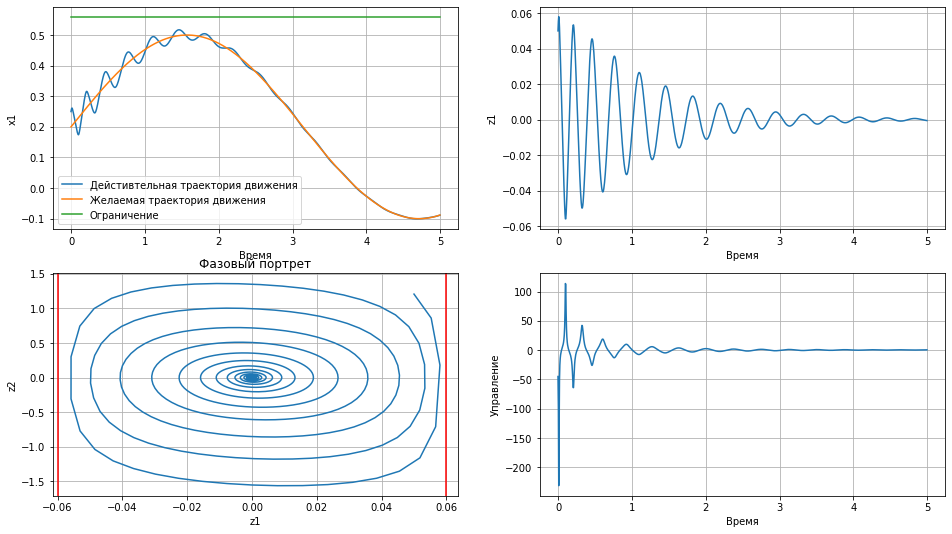

In [54]:
# Построение графиков
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(2, 2, 1)
ax.plot(T, x[0], label='Дейстивтельная траектория движения')
ax.plot(T, 0.2 + 0.3 * np.sin(T), label='Желаемая траектория движения')
ax.set_xlabel('Время')
ax.set_ylabel('x1')
ax.plot(T, k_c * np.ones(len(T)), label='Ограничение')
ax.grid()
ax.legend()

ax = fig.add_subplot(2, 2, 2)
ax.plot(T, z1_plot)
ax.set_xlabel('Время')
ax.set_ylabel('z1')
ax.grid()

ax = fig.add_subplot(2, 2, 3)
ax.plot(z1_plot, z2_plot)
ax.axvline(x = k_b, color='red')
ax.axvline(x = -k_b, color='red')
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_title('Фазовый портрет')
ax.grid()

ax = fig.add_subplot(2, 2, 4)
ax.plot(T, ctrl)
ax.set_xlabel('Время')
ax.set_ylabel('Управление')
ax.grid()
plt.show()

Теперь управляем при помощи асимметричного барьера:

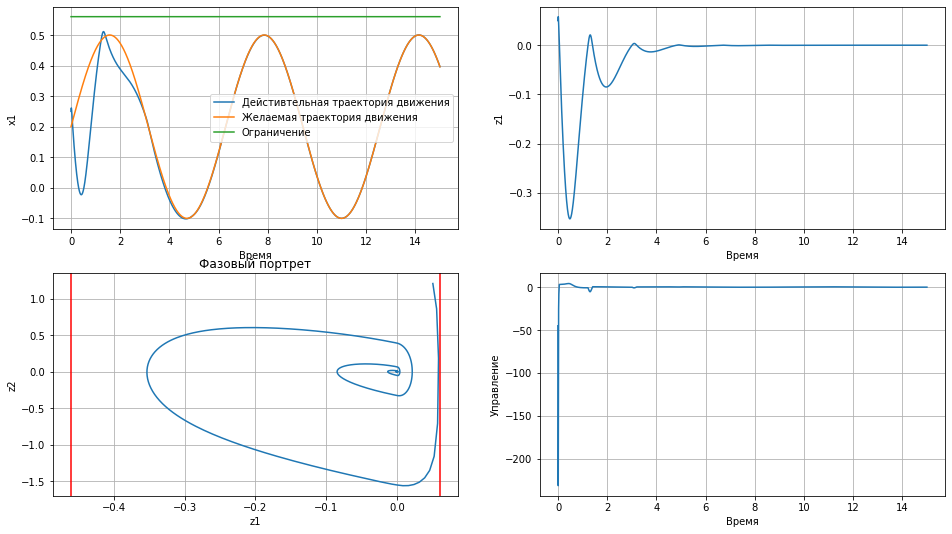

In [55]:
# Функция для расчёта управления. Здесь также задаются параметры m и p
def control(time, x):
    # global i
    m = 3
    p = 2
    # Здесь устанавливается величина q на каждом шаге
    if z1.subs({x1: x[0], t: time}) > 0:
        q = 1
    else:
        q = 0
    alpha = 1 / g1 * (- f1 - (q * (k_b ** p - z1 ** p) + (1 - q) * (k_a ** p - z1 ** p)) * k[1] * (z1 ** m) + sym.diff(y_d, t))
    z2 = x2 - alpha
    # С помощью sympy проводится дифференцирование функций
    alpha_dot = sym.diff(alpha, x1) * (f1 + g1 * x2) + sym.diff(alpha, t)
    u = 1 / g2 * (- f2 + alpha_dot - k[2] * z2 - g1 * z1 ** (p - 1) * (
            q / (k_b ** p - z1 ** p) + (1 - q) / (k_a ** p - z1 ** p)))
    return u.subs({t: time, x1: x[0], x2: x[1]}), z1.subs({t: time, x1: x[0]}), z2.subs({t: time, x1: x[0], x2: x[1]})


# Задание начального положения и времени наблюдений
x0 = np.array([0.25, 1.5])
t0 = 0
tf = 15
dt = 0.005
t_eval = np.arange(t0, tf, dt)

# Непосредственное решение системы уравнений
solution = solve_ivp(lambda time, x: rhs(time, x), (t0, tf), x0, t_eval=t_eval)
x = solution.y
T = solution.t

# Поскольку управление зависит от системы и меняется на каждом шаге, необходимо достать его 
ctrl = np.zeros(int((tf - t0) / dt))
z1_plot = np.zeros(int((tf - t0) / dt))
z2_plot = np.zeros(int((tf - t0) / dt))
for i in range(len(T)):
    ctrl[i], z1_plot[i], z2_plot[i] = control(T[i], [x[0, i], x[1, i]])

# Построение графиков
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(2, 2, 1)
ax.plot(T, x[0], label='Дейстивтельная траектория движения')
ax.plot(T, 0.2 + 0.3 * np.sin(T), label='Желаемая траектория движения')
ax.plot(T, k_c * np.ones(len(T)), label='Ограничение')
ax.set_xlabel('Время')
ax.set_ylabel('x1')
ax.grid()
ax.legend()

ax = fig.add_subplot(2, 2, 2)
ax.plot(T, z1_plot)
ax.set_xlabel('Время')
ax.set_ylabel('z1')
ax.grid()

ax = fig.add_subplot(2, 2, 3)
ax.plot(z1_plot, z2_plot)
ax.axvline(x = k_b, color='red')
ax.axvline(x = -k_a, color='red')
ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_title('Фазовый портрет')
ax.grid()

ax = fig.add_subplot(2, 2, 4)
ax.plot(T, ctrl)
ax.set_xlabel('Время')
ax.set_ylabel('Управление')
ax.grid()
plt.show()

Итак, решение системы удовлятворяет ограничению при использовании как симметричного, так и асимметричного барьера. Согласно фазовым портретам можно заключить, что асимметичный барьер **расширяет** набор допустимых значений отклонений $z_{1}$ и $z_{2}$ т.е. увеличивает диапазон задания начальных условий. При этом поведение $z_{1}$ и управления симметрично для симметричного барьера и наоборот. В асимметричном барьере управление нужно прикладывать реже, что экономит ресурсы. 